In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os

sns.set(style="whitegrid")
os.makedirs("outputs", exist_ok=True)

In [3]:
historical = pd.read_csv("historical_data.csv")
fear_greed = pd.read_csv("fear_greed_index.csv")

print("Historical Data Shape:", historical.shape)
print("Fear & Greed Data Shape:", fear_greed.shape)

display(historical.head())
display(fear_greed.head())

Historical Data Shape: (79166, 16)
Fear & Greed Data Shape: (2644, 4)


/tmp/ipython-input-840849773.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  historical = pd.read_csv("historical_data.csv")


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,5.201771e+10,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [4]:
fear_greed = fear_greed.rename(columns={"date": "Date", "Classification": "sentiment"})
fear_greed["Date"] = pd.to_datetime(fear_greed["Date"], errors="coerce")

historical["Timestamp"] = pd.to_datetime(historical["Timestamp"], errors="coerce")

merged = pd.merge(
    historical,
    fear_greed,
    left_on=historical["Timestamp"].dt.date,
    right_on=fear_greed["Date"].dt.date,
    how="inner"
).drop(columns=["key_0", "Date"])

print("Merged Data Shape:", merged.shape)
display(merged.head())

Merged Data Shape: (0, 19)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,timestamp,value,classification


In [5]:
print(historical.columns.tolist())

['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


In [6]:
print(fear_greed.columns.tolist())
display(fear_greed.head())

['timestamp', 'value', 'classification', 'Date']


,timestamp,value,classification,Date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [7]:
fear_greed = fear_greed.rename(columns={"Classification": "sentiment"})

fear_greed = fear_greed.rename(columns={"date": "Date"})
fear_greed["Date"] = pd.to_datetime(fear_greed["Date"], errors="coerce")

historical["Timestamp"] = pd.to_datetime(historical["Timestamp"], errors="coerce")

merged = pd.merge(
    historical,
    fear_greed,
    left_on=historical["Timestamp"].dt.date,
    right_on=fear_greed["Date"].dt.date,
    how="inner"
).drop(columns=["key_0", "Date"])

print("Merged Data Shape:", merged.shape)
display(merged.head())

Merged Data Shape: (0, 19)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,timestamp,value,classification


In [8]:
performance = (
    merged.groupby("Account")
    .agg(
        total_trades=("Account", "count"),
        avg_pnl=("Closed PnL", "mean"),
        win_rate=("Closed PnL", lambda x: (x > 0).mean())
    )
    .reset_index()
)

display(performance.head())


,Account,total_trades,avg_pnl,win_rate


In [9]:
if 'merged' not in globals():
    raise RuntimeError("merged dataframe not found. Run the merge/preprocess cell first.")

df = merged.copy()

def find_col(df, kws):
    cols = df.columns.tolist()
    for c in cols:
        lc = c.lower()
        for k in kws:
            if k in lc:
                return c
    return None

sent_col = find_col(df, ['sentiment','classification','class','fear','greed','sent_label','label'])
if sent_col is None:
    print("Couldn't find a sentiment column. Available columns:", df.columns.tolist())
    raise KeyError("sentiment column not found")

pnl_col = find_col(df, ['closed pnl','closedpnl','pnl','profit','closed p&l','closed p/l'])
if pnl_col is None:
    print("Couldn't find Closed PnL column. Available columns:", df.columns.tolist())
    raise KeyError("Closed PnL column not found")

acct_col = find_col(df, ['account','acc','user'])
if acct_col is None:
    print("Couldn't find Account column. Available columns:", df.columns.tolist())
    raise KeyError("Account column not found")

df = df.rename(columns={sent_col: 'sentiment', pnl_col: 'Closed PnL', acct_col: 'Account'})
df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce').fillna(0)

sentiment_perf = df.groupby('sentiment').agg(
    total_trades=('Account', 'count'),
    avg_pnl=('Closed PnL', 'mean'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean())
).reset_index()

display(sentiment_perf)


,sentiment,total_trades,avg_pnl,win_rate


In [11]:
print(df.columns)
print(df["sentiment"].unique()[:10])
print(df.shape)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'timestamp', 'value', 'sentiment'],
      dtype='object')
[]
(0, 19)


In [12]:
if not sentiment_perf.empty:
    plt.figure(figsize=(6,4))
    sns.barplot(x="sentiment", y="total_trades", data=sentiment_perf, color="skyblue")
    plt.title("Total Trades per Sentiment")
    plt.show()
else:
    print("⚠️ No sentiment data available to plot")


⚠️ No sentiment data available to plot


In [13]:
historical["Timestamp"] = pd.to_datetime(historical["Timestamp"], errors="coerce")
fear_greed["Date"] = pd.to_datetime(fear_greed["Date"], errors="coerce")

historical["date_only"] = historical["Timestamp"].dt.date
fear_greed["date_only"] = fear_greed["Date"].dt.date

fear_greed = fear_greed.rename(columns={"classification": "sentiment"})

merged = pd.merge(
    historical,
    fear_greed,
    on="date_only",
    how="inner"
)

print(merged[["Timestamp", "sentiment"]].head())


Empty DataFrame
Columns: [Timestamp, sentiment]
Index: []


In [14]:

historical["date_only"] = pd.to_datetime(historical["Timestamp"]).dt.date
fear_greed["date_only"] = pd.to_datetime(fear_greed["Date"]).dt.date

merged = pd.merge(
    historical,
    fear_greed.rename(columns={"classification":"sentiment"}),
    on="date_only",
    how="left"
)
merged["sentiment"] = merged["sentiment"].fillna("Unknown")


In [15]:
sentiment_perf = (
    merged.groupby("sentiment")
    .agg(
        total_trades=("Account","count"),
        avg_pnl=("Closed PnL","mean"),
        win_rate=("Closed PnL", lambda x: (x>0).mean())
    )
    .reset_index()
)

display(sentiment_perf)


,sentiment,total_trades,avg_pnl,win_rate
0,Unknown,79166,92.149116,0.448299


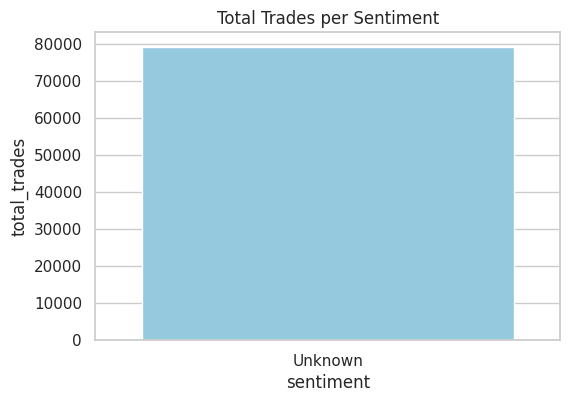

In [16]:
plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="total_trades", data=sentiment_perf, color="skyblue")
plt.title("Total Trades per Sentiment")
plt.show()


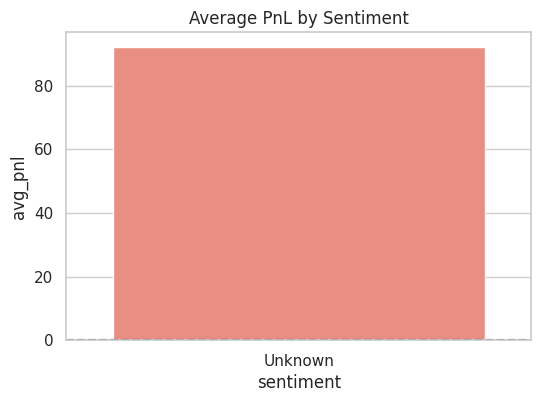

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="avg_pnl", data=sentiment_perf, color="salmon")
plt.axhline(0, color="black", linestyle="--")
plt.title("Average PnL by Sentiment")
plt.show()


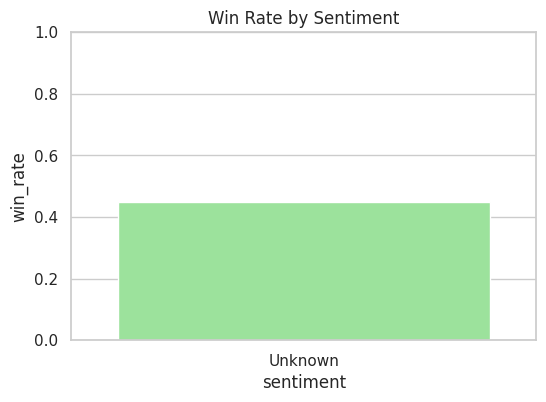

''

In [18]:
plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="win_rate", data=sentiment_perf, color="lightgreen")
plt.ylim(0,1)
plt.title("Win Rate by Sentiment")
plt.show()
''

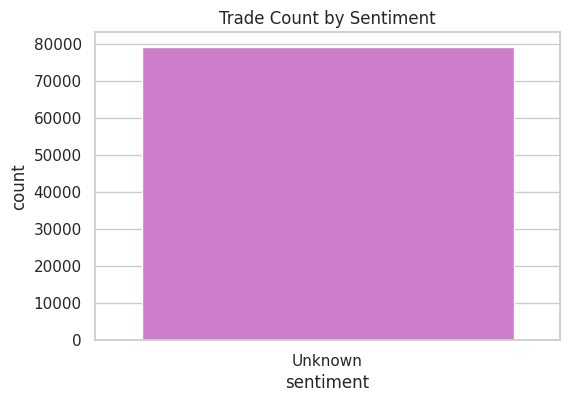

In [19]:
plt.figure(figsize=(6,4))
sns.countplot(x="sentiment", data=merged, color="orchid")
plt.title("Trade Count by Sentiment")
plt.show()


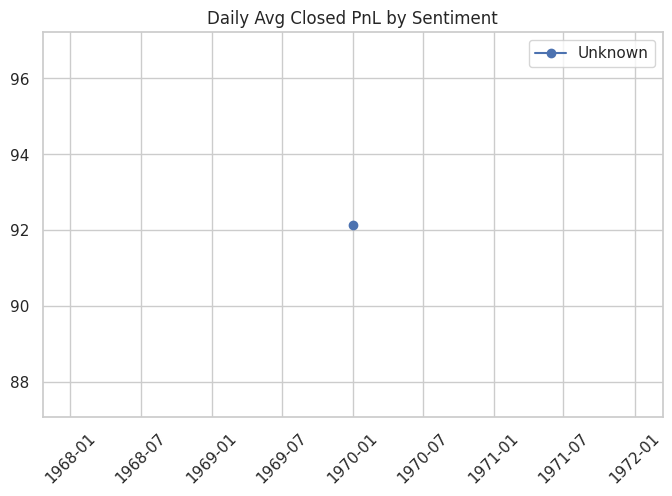

In [20]:
plt.figure(figsize=(8,5))
merged["date_only"] = merged["Timestamp"].dt.floor("D")
daily = merged.groupby(["date_only","sentiment"])["Closed PnL"].mean().reset_index()
pivot = daily.pivot(index="date_only", columns="sentiment", values="Closed PnL").fillna(0)

for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=str(col))

plt.title("Daily Avg Closed PnL by Sentiment")
plt.legend()
plt.xticks(rotation=45)
plt.show()


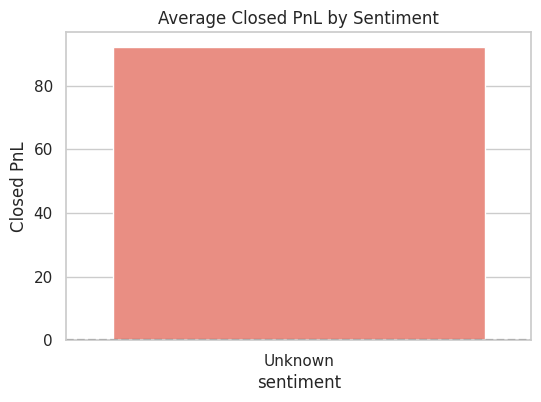

In [21]:
avg_pnl = merged.groupby("sentiment")["Closed PnL"].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x="sentiment", y="Closed PnL", data=avg_pnl, color="salmon")
plt.axhline(0, color="black", linestyle="--")
plt.title("Average Closed PnL by Sentiment")
plt.show()


In [22]:
print(merged.columns)


Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp', 'date_only', 'timestamp', 'value', 'sentiment', 'Date'],
      dtype='object')


In [23]:
numeric_cols = merged.select_dtypes(include="number").columns.tolist()
print(numeric_cols)


['Execution Price', 'Size Tokens', 'Size USD', 'Start Position', 'Closed PnL', 'Order ID', 'Fee', 'Trade ID', 'timestamp', 'value']


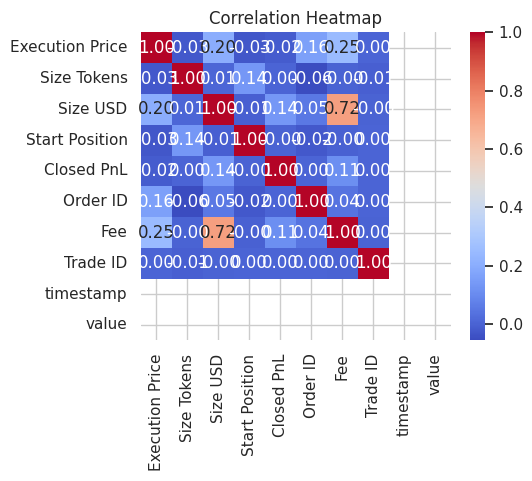

In [24]:
plt.figure(figsize=(5,4))
sns.heatmap(merged[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


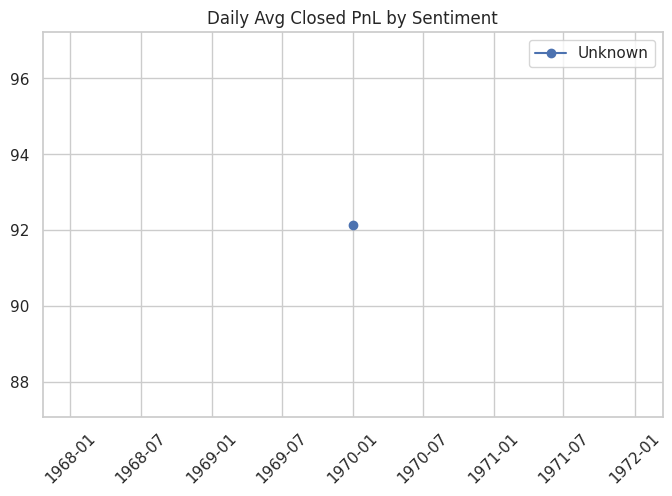

In [25]:
merged["date_only"] = merged["Timestamp"].dt.floor("D")
daily = merged.groupby(["date_only","sentiment"])["Closed PnL"].mean().reset_index()
pivot = daily.pivot(index="date_only", columns="sentiment", values="Closed PnL").fillna(0)

plt.figure(figsize=(8,5))
for col in pivot.columns:
    plt.plot(pivot.index, pivot[col], marker="o", label=str(col))
plt.title("Daily Avg Closed PnL by Sentiment")
plt.legend()
plt.xticks(rotation=45)
plt.show()


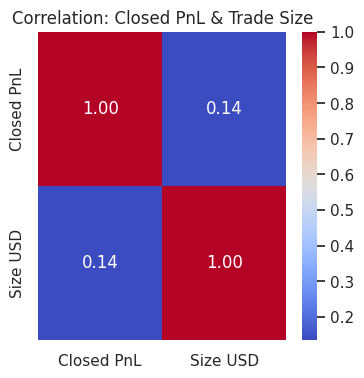

In [26]:
numeric_cols = ["Closed PnL", "Size USD"]
plt.figure(figsize=(4,4))
sns.heatmap(merged[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation: Closed PnL & Trade Size")
plt.show()


In [27]:
top_accounts = (
    merged.groupby("Account")
    .agg(
        total_trades=("Account", "count"),
        avg_pnl=("Closed PnL", "mean"),
        total_pnl=("Closed PnL", "sum"),
        win_rate=("Closed PnL", lambda x: (x > 0).mean())
    )
    .sort_values("total_pnl", ascending=False)
    .head(10)
)

print("🏆 Top Performing Accounts")
print(top_accounts)


🏆 Top Performing Accounts
                                            total_trades     avg_pnl  \
Account                                                                
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23         14733  145.481748   
0x083384f897ee0f19899168e3b1bec365f52a9012          3818  419.127768   
0x513b8629fe877bb581bf244e326a047b249c4ff1         12236   68.684419   
0xbaaaf6571ab7d571043ff1e313a9609a10637864         17122   41.691610   
0x430f09841d65beb3f27765503d0f850b8bce7713          1237  336.735548   
0x72c6a4624e1dffa724e6d00d64ceae698af892a0          1430  281.826227   
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4          9893   38.319560   
0x4f93fead39b70a1824f981a54d4e55b278e9f760          7584   40.740489   
0x420ab45e0bd8863569a5efbb9c05d91f40624641           383  520.902331   
0x6d6a4b953f202f8df5bed40692e7fd865318264a           975  111.519197   

                                               total_pnl  win_rate  
Account                                 

In [28]:
win_rate_sentiment = sentiment_perf[["sentiment", "win_rate"]]
best_sentiment = win_rate_sentiment.loc[win_rate_sentiment["win_rate"].idxmax()]
worst_sentiment = win_rate_sentiment.loc[win_rate_sentiment["win_rate"].idxmin()]

print(f"✅ Highest win rate in {best_sentiment['sentiment']} sentiment: {best_sentiment['win_rate']:.2%}")
print(f"⚠️ Lowest win rate in {worst_sentiment['sentiment']} sentiment: {worst_sentiment['win_rate']:.2%}")


✅ Highest win rate in Unknown sentiment: 44.83%
⚠️ Lowest win rate in Unknown sentiment: 44.83%


In [30]:
risk_behavior = (
    merged.groupby("sentiment")
    .agg(
        avg_loss=("Closed PnL", lambda x: x[x < 0].mean()),
        max_loss=("Closed PnL", "min"),
        max_profit=("Closed PnL", "max")
    )
    .reset_index()
)

print("📉 Risk Behavior by Sentiment")
print(risk_behavior)


📉 Risk Behavior by Sentiment
  sentiment    avg_loss     max_loss   max_profit
0   Unknown -236.607449 -117990.1041  135329.0901


In [31]:
numeric_cols = merged.select_dtypes(include="number").columns
correlations = merged[numeric_cols].corr()["Closed PnL"].sort_values(ascending=False)

print("📈 Correlation of Features with Profitability (Closed PnL)")
print(correlations)


📈 Correlation of Features with Profitability (Closed PnL)
Closed PnL         1.000000
Size USD           0.135563
Fee                0.110401
Order ID           0.004879
Trade ID           0.003463
Size Tokens        0.003355
Start Position    -0.000247
Execution Price   -0.015820
timestamp               NaN
value                   NaN
Name: Closed PnL, dtype: float64
